# Stellar Mass Profiles

This script seeks to reproduce the stellar mass profiles from Pillepich 2018 using the IllustrisTNG-100 and IllustrisTNG-300 simulations.

* Central galaxies - do not reside within $R_{200c}$ or $R_{500c}$ of a larger halo
* Satellite galaxies - reside within a certain 3D spherical aperture
* Intra-cluster light (ICL) - the stellar mass particles beyond this fixed aperture but within the maximum boundary of the virial radius
* Diffuse mass - all stellar mass in a group and cluster within the virial radius (central+ICL)
* The total stellar mass of a group or cluster is the sum of all components (central+ICL+satellites)

Useful Information:
* A stellar particle can be associated to only one galaxy (central or satellite)
* Might need to adopt initial mass function (IMF) from Chabrier (2003)
    * The IMF specifies the fractional distribution in mass of a newly formed stellar system. 


Information needed from IllustrisTNG100 and TNG300 for stellar mass profiles

For the central galaxy, we need:

* Need to implement mass cut because the paper only focuses on groups/clusters with masses of $10^{13} <= M_{200c}/M_{sol} <= 10^{15}$ 
    * This appears to be Group_M_Mean_200 in IllustrisTNG
    * Total Mass of this group enclosed in a sphere whose mean density is 200 times the mean density of the Universe, at the time the halo is considered.
    * The mass of the central galaxy is always defined within a fixed 3D aperture
    * Stellar mass can be obtained using "SubhaloMassType" -> "Masses" in PartType4. Adding up all of the masses in the cell within a given radius (aperture) will allow us to obtain the mass of the central galaxy
* The central galaxy stellar mass is defined as the sum of all stellar particles mass within fixed apertures (3D, 10, 30, 100 physics or comoving kpc)
* Intra-cluster light (ICL) - the stellar mass particles beyond this fixed aperture but within the maximum boundary of the virial radius
* Stellar half mass radius - measured as the 3D radius containing half of the stellar mass of all constituent stars
    * This is "SubhaloMassInHalfRadType" in IllustrisTNG
* Redshifts z<1
    * Snapshot 50-99 cover redshifts between 0 and 1
* Virial radius (R_200c)
* Stellar mass within half mass radius

For the satellite galaxies, we need:


    
For stellar mass density projections, we need:
* Coordinates of the center of the galaxy
* Surface mass densities ($0.1-10e10 M_{sol} kpc^{-2}$)



In [3]:
import illustris_python as il
import h5py
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

/Users/sandyspicer/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [20]:
import requests

baseUrl = 'http://www.illustris-project.org/api/'
headers = {"api-key":"4e2c93455bbc8e991a91a61ef5e11daa"}

def get(path, params=None):
    # make HTTP GET request to path
    r = requests.get(path, params=params, headers=headers)

    # raise exception if response code is not HTTP SUCCESS (200)
    r.raise_for_status()
    if r.headers['content-type'] == 'application/json':
        return r.json() # parse json responses automatically
    return r

# Steps - Copy in terminal window
* mkdir IllustrisTNG100-3
* mkdir IllustrisTNG100-3/groups_99
* cd IllustrisTNG100-3/groups_99/
* wget -nd -nc -nv -e robots=off -l 1 -r -A hdf5 --content-disposition --header="API-Key: 4e2c93455bbc8e991a91a61ef5e11daa" "http://www.illustris-project.org/api/TNG100-3/files/groupcat-99/?format=api"

In [21]:
basePath = '/Users/sandyspicer/Desktop/Research_with_Moustakas/stellar_mass_profiles/IllustrisTNG100-3/output'
fields = ['SubhaloMass','SubhaloMassType','SubhaloSFRinRad']
subhalos = il.groupcat.loadSubhalos(basePath,99,fields=fields)

Text(0,0.5,'Star Formation Rate [$M_\\odot / yr$]')

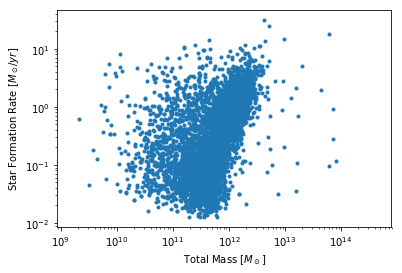

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

mass_msun = subhalos['SubhaloMass'] * 1e10 / 0.704
plt.plot(mass_msun,subhalos['SubhaloSFRinRad'],'.')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Total Mass [$M_\odot$]')
plt.ylabel('Star Formation Rate [$M_\odot / yr$]')

* GroupFirstSub - Index into the Subhalo table of the first/primary/most massive Subfind group within this FoF group. Note: This value is signed (or should be interpreted as signed)! In this case, a value of -1 indicates that this FoF group has no subhalos.
* Group_R_Crit200 - Comoving Radius of a sphere centered at the GroupPos of this Group whose mean density is 200 times the critical density of the Universe, at the time the halo is considered. In other words, the virial radius.
* GroupCM - Center of mass of the group, computed as the sum of the mass weighted relative coordinates of all particles/cells in the group, of all types. Comoving coordinate. 
* GroupPos - Spatial position within the periodic box (of the particle with the minimum gravitational potential energy). Comoving coordinate.
* GroupMassType - Sum of the individual masses of every particle/cell, split into the six different types, in this group. Note: Wind phase cells are counted as gas (type 0) for GroupMassType.

Every FoF group is associated to one central SUBFIND halo and possibly a halo of satellite objects

In [23]:
import h5py
f = h5py.File('/Users/sandyspicer/Desktop/Research_with_Moustakas/stellar_mass_profiles/IllustrisTNG100-3/output/groups_099/fof_subhalo_tab_099.0.hdf5', 'r')

In [24]:
list(f)

['Config', 'Group', 'Header', 'IDs', 'Parameters', 'Subhalo']

In [25]:
list(f['Group'])

['GroupBHMass',
 'GroupBHMdot',
 'GroupCM',
 'GroupFirstSub',
 'GroupGasMetalFractions',
 'GroupGasMetallicity',
 'GroupLen',
 'GroupLenType',
 'GroupMass',
 'GroupMassType',
 'GroupNsubs',
 'GroupPos',
 'GroupSFR',
 'GroupStarMetalFractions',
 'GroupStarMetallicity',
 'GroupVel',
 'GroupWindMass',
 'Group_M_Crit200',
 'Group_M_Crit500',
 'Group_M_Mean200',
 'Group_M_TopHat200',
 'Group_R_Crit200',
 'Group_R_Crit500',
 'Group_R_Mean200',
 'Group_R_TopHat200']

In [26]:
# Load parameters for snapshot 99 (redshift 0)
GroupFirstSub = f['Group']['GroupFirstSub']
Group_R_Crit200 = f['Group']['Group_R_Crit200']
GroupCM = f['Group']['GroupCM']
GroupPos = f['Group']['GroupPos']
GroupMassType = f['Group']['GroupMassType']

In [27]:
list(f['Group']['Group_M_Crit200'])

[25268.787,
 25467.057,
 22858.674,
 11426.892,
 17188.771,
 13325.995,
 14002.103,
 14234.35,
 5891.2344,
 14541.415,
 10908.741,
 8874.756,
 5363.882,
 3248.6284,
 7680.481]

In [28]:
# All of the central galaxies indices in snapshot 99
central_galaxies = list(GroupFirstSub)
print(central_galaxies)

[0, 544, 953, 1285, 1662, 1893, 2164, 2383, 2641, 2879, 3043, 3229, 3403, 3605, 3760]


In [29]:
ptNumGas = il.snapshot.partTypeNum('gas') # 0
ptNumStars = il.snapshot.partTypeNum('stars') # 4

stellarmass = []
gasmass = []
totalmass = []

for i in range(5):
    all_fields = il.groupcat.loadSingle(basePath,99,subhaloID=GroupFirstSub[i])
    gas_mass   = all_fields['SubhaloMassInHalfRadType'][ptNumGas]
    stars_mass = all_fields['SubhaloMassInHalfRadType'][ptNumStars]
    gas_mass   = all_fields['SubhaloMassType'][ptNumGas]
    stars_mass = all_fields['SubhaloMassType'][ptNumStars]
    total_mass = all_fields['SubhaloMass']
    stellarmass.append(stars_mass)
    gasmass.append(gas_mass)
    totalmass.append(total_mass)

In [30]:
print(totalmass)

[29804.924, 29481.428, 24644.398, 15315.601, 16710.242]


In [31]:
f2 = h5py.File('/Users/sandyspicer/Desktop/Research_with_Moustakas/stellar_mass_profiles/IllustrisTNG100-3/output/groups_099/cutout_544.hdf5', 'r')

In [32]:
stellar_hsml = list(f2['PartType4']['StellarHsml'])

In [33]:
stellar_masses = list(f2['PartType4']['Masses'])

In [34]:
birth_pos = list(f2['PartType4']['BirthPos'])

In [35]:
coordinates = list(f2['PartType4']['Coordinates'])

In [18]:
stellar_hsml = np.array(stellar_hsml)
stellar_masses = np.array(stellar_masses)
print(len(stellar_masses))

18314


In [36]:
subhalo_mass = []
subhalo_position = []
subhalo_sfr = []
subhalo_masstype = []
subhalo_metallicity = []
subhalo_cm = []
subhalo_pos = []

for c in central_galaxies:
    snap_url = "http://www.tng-project.org/api/TNG100-3/snapshots/99/subhalos/"+str(c)+"/info.json"
    #snap_url = "http://www.tng-project.org/api/TNG100-3/snapshots/99/subhalos/"+str(c)+"/cutout.hdf5"
    snap = get(snap_url)
    subhalo_mass.append(snap['SubhaloMass'])
    subhalo_position.append(snap['SubhaloPos'])
    subhalo_sfr.append(snap['SubhaloSFR'])
    subhalo_masstype.append(snap['SubhaloMassType'])
    subhalo_metallicity.append(snap['SubhaloGasMetallicity'])
    subhalo_cm.append(snap['SubhaloCM'])
    subhalo_pos.append(snap['SubhaloPos'])
    

In [37]:
central_galaxy = subhalo_pos[0]
radius = []

for c in range(0,len(coordinates)):
    x = coordinates[c][0]-central_galaxy[0]
    y = coordinates[c][1]-central_galaxy[1]
    z = coordinates[c][2]-central_galaxy[2]
    
#     x = birth_pos[c][0]-central_galaxy[0]
#     y = birth_pos[c][1]-central_galaxy[1]
#     z = birth_pos[c][2]-central_galaxy[2]
    
    radius.append(np.sqrt(x**2 + y**2 + z**2))

In [38]:
print(central_galaxy[0])
print(coordinates[13][0])

851.4019775390625
19725.840169183204


In [39]:
print(radius)

[41772.43522538216, 41773.69611381911, 41773.06684967799, 41773.271832180566, 41772.939607394364, 41774.5114819194, 41773.14429734205, 41773.665809283244, 41773.51110054935, 41773.86964541, 41772.50546732213, 41774.25031471215, 41773.8928297353, 41773.04664389232, 41773.25003390758, 41772.888753721665, 41772.338215964686, 41773.713145931244, 41773.610486031146, 41773.323851205896, 41775.110732983616, 41774.30580452228, 41774.2209824312, 41774.8689570484, 41772.71149664989, 41772.94111267923, 41773.119741090784, 41773.44141026017, 41772.918113907595, 41773.42843167434, 41771.65474403591, 41774.39238072263, 41772.89392252472, 41774.87191756403, 41773.91676967371, 41773.08200871155, 41773.74918892871, 41772.414448213574, 41774.6954858447, 41772.516079183806, 41775.78069120032, 41774.24925621796, 41771.06604419108, 41773.27520316116, 41771.58053878645, 41772.089436786606, 41774.8896395616, 41774.92493098948, 41773.365730741454, 41773.5558091563, 41774.09784106086, 41772.1984601097, 41773.3

In [40]:
gas_mass = []
stellar_mass = []

print(len(subhalo_masstype))
for m in range(0,len(subhalo_masstype)):
    gas_mass.append(subhalo_masstype[m][0])
    stellar_mass.append(subhalo_masstype[m][1])
    
#print(gas_mass)
print(stellar_mass)

15
[25223.3515625, 25396.427734375, 20868.294921875, 12898.4375, 14111.0078125, 13384.080078125, 13637.1748046875, 13180.783203125, 7841.044921875, 12423.2470703125, 11098.59375, 8965.248046875, 7397.4658203125, 2952.942138671875, 7368.21533203125]


In [70]:
sum_stellar_mass = []
for r in range(0,len(radius)):
    w = np.where(radius<radius[r])
    new_stellar_mass = stellar_masses
    summed_mass = np.sum(new_stellar_mass[w])
    sum_stellar_mass.append(summed_mass)
    
#print(sum_stellar_mass)

TypeError: list indices must be integers or slices, not tuple

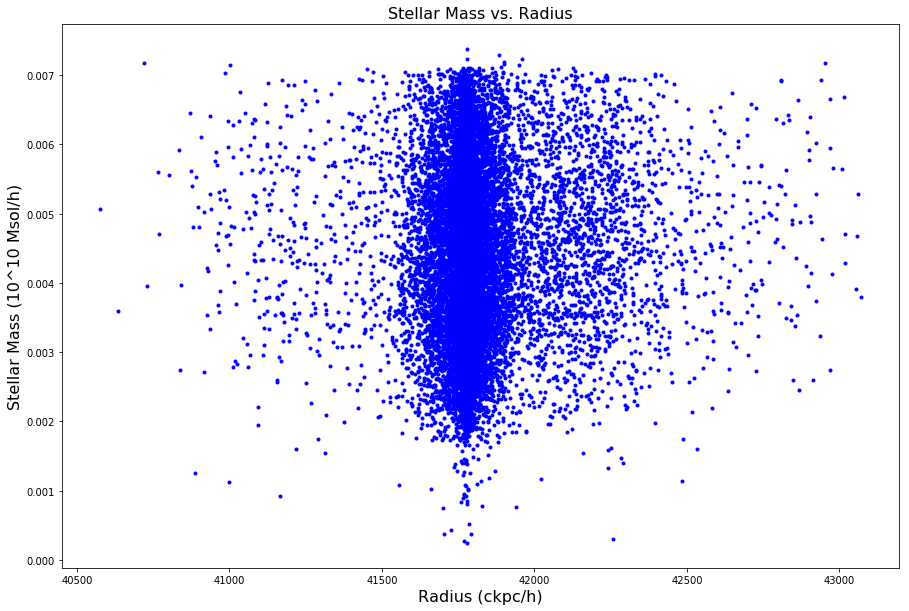

In [42]:
plt.figure(figsize=(15,10))
plt.plot(radius, stellar_masses, 'b.')
plt.title('Stellar Mass vs. Radius',fontsize=16)
plt.xlabel('Radius (ckpc/h)',fontsize=16)
plt.ylabel('Stellar Mass (10^10 Msol/h)',fontsize=16)
plt.savefig('stellarmass_vs_radius.png')

This function takes in a relation number as an integer and returns y (the stellar mass). The function also plots the corresponding fitting function in log scale with a label. Possible number inputs are 1-9. Refer to Table 4 in Pillepich et al. 2018 to determine the number for each fitting function.

In [4]:
# This function takes in a relation number as an integer and returns y (the stellar mass). The function also plots 
# the corresponding fitting function in log scale with a label. Possible number inputs are 1-9. Refer to Table 4 
# in Pillepich et al. 2018 to determine the number for each fitting function.

def illustris_relation(relation):
    Msol = 1
    M_500c = np.linspace(13,15)
    m = M_500c/Msol
    m0 = 14
    
    if relation == 1:
        a = 0.49
        b = 11.77
        sig = 0.12
        y = a*(m-m0)+b
        plot_label = "Central < 30 kpc"
        ylabel = r"Stellar Mass ($M_{stars, cen}$/$M_{\odot}$)"
        plt.fill_between(m,y+sig,y-sig,alpha=0.5)
        
    if relation == 2:
        a = 0.59
        b = 12
        sig = 0.13
        y = a*(m-m0)+b
        plot_label = "Central < 100 kpc"
        ylabel = r"Stellar Mass ($M_{stars, cen}$/$M_{\odot}$)"
        plt.fill_between(m,y+sig,y-sig,alpha=0.5)
        
    if relation == 3:
        a = 0.74
        b = 12.02
        sig = 0.12
        y = a*(m-m0)+b
        plot_label = "Central < 2 x r_(stars, 1/2)"
        ylabel = r"Stellar Mass ($M_{stars, cen}$/$M_{\odot}$)"
        plt.fill_between(m,y+sig,y-sig,alpha=0.5)
        
    if relation == 4:
        a = 1.01
        b = 12.01
        sig = 0.13
        y = a*(m-m0)+b
        plot_label = "ICL > 30 kpc"
        ylabel = r"Stellar Mass ($M_{stars, ICL}$/$M_{\odot}$)"
        plt.fill_between(m,y+sig,y-sig,alpha=0.5)
        
    if relation == 5:
        a = 1.25
        b = 11.74
        sig = 0.14
        y = a*(m-m0)+b
        plot_label = "ICL > 100 kpc"
        ylabel = r"Stellar Mass ($M_{stars, ICL}$/$M_{\odot}$)"
        plt.fill_between(m,y+sig,y-sig,alpha=0.5)
        
    if relation == 6:
        a = 0.77
        b = 11.72
        sig = 0.11
        y = a*(m-m0)+b
        plot_label = "ICL > 2 x r_(stars, 1/2)"
        ylabel = r"Stellar Mass ($M_{stars, ICL}$/$M_{\odot}$)"
        plt.fill_between(m,y+sig,y-sig,alpha=0.5)
        
    if relation == 7:
        a = 1.14
        b = 11.93
        sig = 0.22
        y = a*(m-m0)+b
        plot_label = "Satellites > 1e8 Msun"
        ylabel = r"Stellar Mass ($M_{stars, sats}$/$M_{\odot}$)"
        plt.fill_between(m,y+sig,y-sig,alpha=0.5)
        
    if relation == 8:
        a = 0.75
        b = 12.19
        sig = 0.11
        y = a*(m-m0)+b
        plot_label =  "Total: central+ICL"
        ylabel = r"Stellar Mass ($M_{stars, tot}$/$M_{\odot}$)"
        plt.fill_between(m,y+sig,y-sig,alpha=0.5)
        
    if relation == 9:
        a = 0.84
        b = 12.36
        sig = 0.07
        y = a*(m-m0)+b
        plot_label = "Total: central+ICL+satellites"
        ylabel = r"Stellar Mass ($M_{stars, tot}$/$M_{\odot}$)"
        plt.fill_between(m,y+sig,y-sig,alpha=0.5)

        
    plt.plot(M_500c,y,label = plot_label)
    plt.legend()
    plt.xlabel(r"Total Halo Mass ($M_{500c}$/$M_{\odot}$)")
    plt.ylabel(ylabel)
             
    return y

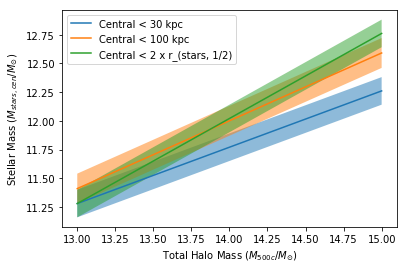

In [5]:
Mstarcentral_Mhalo_30kpc = illustris_relation(1)
Mstarcentral_Mhalo_100kpc = illustris_relation(2)
Mstarcentral_Mhalo_hmr = illustris_relation(3)

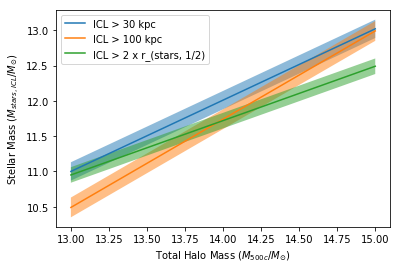

In [6]:
MstarICL_Mhalo_30kpc = illustris_relation(4)
MstarICL_Mhalo_100kpc = illustris_relation(5)
MstarICL_Mhalo_hmr = illustris_relation(6)

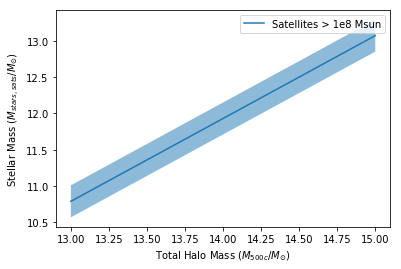

In [7]:
Mstarsat_Mhalo_1e8Msol = illustris_relation(7)

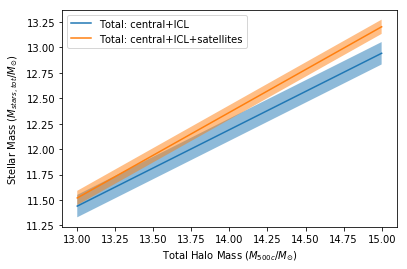

In [8]:
Mstardiff_Mhalo_cenICL = illustris_relation(8)
Mstartot_Mhalo_cenICLsats = illustris_relation(9)

array([11.52      , 11.55428571, 11.58857143, 11.62285714, 11.65714286,
       11.69142857, 11.72571429, 11.76      , 11.79428571, 11.82857143,
       11.86285714, 11.89714286, 11.93142857, 11.96571429, 12.        ,
       12.03428571, 12.06857143, 12.10285714, 12.13714286, 12.17142857,
       12.20571429, 12.24      , 12.27428571, 12.30857143, 12.34285714,
       12.37714286, 12.41142857, 12.44571429, 12.48      , 12.51428571,
       12.54857143, 12.58285714, 12.61714286, 12.65142857, 12.68571429,
       12.72      , 12.75428571, 12.78857143, 12.82285714, 12.85714286,
       12.89142857, 12.92571429, 12.96      , 12.99428571, 13.02857143,
       13.06285714, 13.09714286, 13.13142857, 13.16571429, 13.2       ])

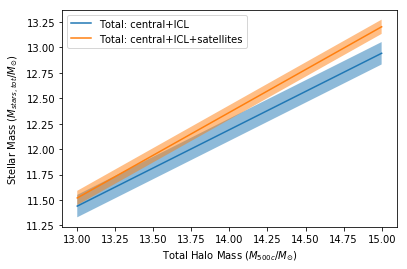

In [9]:
illustris_relation(8)
illustris_relation(9)

In [23]:
def get_R200c(function_of_mass,M_halo):
    
    if function_of_mass == 1:
        a = 0.33
        b = 2.99
        m = M_halo - 14
        R_200c = a*m+b
        
    if function_of_mass == 2:
        a = 0.70
        b = 2.88
        m = M_halo - 11.5
        R_200c = a*m+b
        
    return R_200c

def get_Mstars_200c(function_of_mass,M_halo):
    
    if function_of_mass == 1: 
        a = 0.74
        b = 12.04
        m = M_halo - 14
        Mstars_200c = a*m+b
        
    if function_of_mass == 2: 
        a = 1.56
        b = 11.80
        m = M_halo - 11.5
        Mstars_200c = a*m+b
        
    return Mstars_200c
        

def get_sigmoidal_slope(function_of_mass,M_halo):
    
    if function_of_mass == 1:
        a = -0.25
        b = 2.14
        m = M_halo - 14
        sigmoidal_slope = a*m+b
        
    if function_of_mass == 2:
        a = -0.52
        b = 2.22
        m = M_halo - 11.5
        sigmoidal_slope = a*m+b
        
    return sigmoidal_slope

def get_x05(function_of_mass,M_halo):
    
    if function_of_mass == 1:  
        a = 0.19
        b = -1.42
        m = M_halo - 14
        x05 = a*m+b
        
    if function_of_mass == 2:
        a = 0.41
        b = -1.48
        m = M_halo - 11.5
        x05 = a*m+b
        
    return x05

def sigmoid_function(function_of_mass,M_halo):
    M_halo = np.log10(M_halo)
    r = np.linspace(0,4)
    r200 = get_R200c(function_of_mass,M_halo)
    print(10**r200)
    x = r - r200
    M_tot = get_Mstars_200c(function_of_mass,M_halo)
    M_stars = get_Mstars_200c(function_of_mass,M_halo)/(1+np.exp(-(get_sigmoidal_slope(function_of_mass,M_halo))*(x-get_x05(function_of_mass,M_halo))))
    return x, 10**M_stars, 10**M_tot

457.0881896148752
777.4278625536144
977.2372209558112
2089.2961308540407


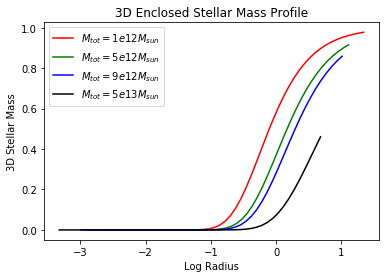

In [26]:
r_r200_1, mstar1, mtot1 = sigmoid_function(1,1e13)
r_r200_2, mstar2, mtot2 = sigmoid_function(1,5e13)
r_r200_3, mstar3, mtot3 = sigmoid_function(1,1e14)
r_r200_4, mstar4, mtot4 = sigmoid_function(1,1e15)
plt.plot(r_r200_1,mstar1/mtot1,'r-',label = r'$M_{tot} = 1e12 M_{sun}$')
plt.plot(r_r200_2,mstar2/mtot2,'g-',label = r'$M_{tot} = 5e12 M_{sun}$')
plt.plot(r_r200_3,mstar3/mtot3,'b-',label = r'$M_{tot} = 9e12 M_{sun}$')
plt.plot(r_r200_4,mstar4/mtot4,'k-',label = r'$M_{tot} = 5e13 M_{sun}$')
#plt.xlim(-1.5,0.5)
plt.xlabel('Log Radius')
plt.ylabel("3D Stellar Mass")
plt.title("3D Enclosed Stellar Mass Profile")
plt.legend()

In [17]:
def get_R200c(M_halo, halo=True):
    if halo:
        a, b = 0.33, 2.99
    else:
        a, b = 0.70, 2.88
       
    m = M_halo - 14
    R_200c = a*m+b
    return R_200c

def get_Mstars_200c(M_halo, halo=True):
    if halo:
        a, b = 0.74, 12.04
    else:
        a, b = 1.56, 11.80
    m = M_halo - 14
    Mstars_200c = a*m+b
    return Mstars_200c

def get_sigmoidal_slope(M_halo, halo=True):
    if halo:
        a, b = -0.25, 2.14
    else:
        a, b = -0.52, 2.22
    m = M_halo - 14
    sigmoidal_slope = a*m+b
    return sigmoidal_slope

def get_x05(M_halo, halo=True):
    if halo:
        a, b = 0.19, -1.42
    else:
        a, b = 0.41, -1.48
    m = M_halo - 14
    x05 = a*m+b
    return x05

def enclosed_mstar(M_halo, halo=True):
    logR200c = get_R200c(M_halo, halo=halo)
    logMstar_norm = get_Mstars_200c(M_halo)
    slope = get_sigmoidal_slope(M_halo)
    x05 = get_x05(M_halo)
    
    lograd = np.linspace(0, 4)
    print(M_halo, logMstar_norm, logR200c)
    xx = lograd - logR200c
    
    Mstar_enclosed  = 10**logMstar_norm / (1+np.exp(-slope*(xx-x05)))
    Mstar_enclosed_frac = 10**(np.log10(Mstar_enclosed) - logMstar_norm)

    return xx, Mstar_enclosed_frac

13 11.299999999999999 2.66
13 11.299999999999999 2.66
14 12.04 2.99
14 12.04 2.99
15 12.78 3.3200000000000003
15 12.78 3.3200000000000003


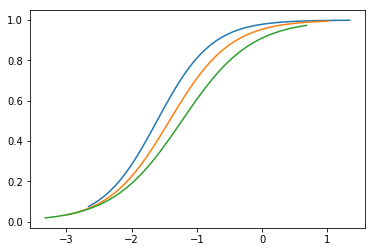

In [19]:
fig, ax = plt.subplots()
for mhalo in (13, 14, 15):
    rad, mstar = enclosed_mstar(mhalo)
    ax.plot(rad, mstar)
    rad, mstar = enclosed_mstar(mhalo, halo=True)
